In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


C:\Users\roger\AppData\Local\Temp\ipykernel_14508\2816518301.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [44]:
import seaborn as sns
import torch

# Iris ডেটাসেট লোড করো
iris = sns.load_dataset('iris')

# Features (4টি) কে float32 tensor বানাও
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# Labels তৈরি করো (0,1,2) অনুযায়ী
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2


In [45]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# ✅ labels must be LongTensor (for classification)
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32),
                              torch.tensor(train_labels, dtype=torch.long))

test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32),
                             torch.tensor(test_labels, dtype=torch.long))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))  # full batch for test


C:\Users\roger\AppData\Local\Temp\ipykernel_14508\2468796170.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32),
C:\Users\roger\AppData\Local\Temp\ipykernel_14508\2468796170.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_labels, dtype=torch.long))
C:\Users\roger\AppData\Local\Temp\ipykernel_14508\2468796170.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32),
C:\Use

In [46]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        self.input = nn.Linear(4, 64)      # ইনপুট ফিচার 4টা
        self.hidden = nn.Linear(64, 64)    # হিডেন লেয়ার
        self.output = nn.Linear(64, 3)     # আউটপুট ক্লাস 3 টা (iris dataset)

        self.dr = dropoutRate              # ড্রপআউট রেট

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)  # CrossEntropyLoss-এর জন্য কোনো activation দরকার নাই
        return x


In [47]:
tmpnet=theModelClass(.25)

tmpdata= torch.rand((10,4))
yhat=tmpnet(tmpdata)
yhat

tensor([[-0.0145,  0.0551,  0.1743],
        [ 0.0303,  0.0618,  0.2366],
        [-0.1713, -0.0389,  0.2381],
        [-0.1900,  0.0492,  0.2948],
        [-0.0748,  0.0582,  0.3133],
        [ 0.0795,  0.0587,  0.0521],
        [-0.0044,  0.0629,  0.2499],
        [ 0.0375, -0.0734,  0.1505],
        [-0.0608,  0.1180,  0.1869],
        [-0.0644,  0.0197,  0.0977]], grad_fn=<AddmmBackward0>)

In [48]:
def createANewModel(dropoutrate):

    ANNQC = theModelClass(dropoutrate)

    lossfun = nn.CrossEntropyLoss()  # multiclass classification এর জন্য

    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.002)

    return ANNQC, lossfun, optimizer


In [49]:
def trainTheModel(ANNQC, lossfun, optimizer, numepochs=500):
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        ANNQC.train()
        batchAcc = []

        for X, y in train_loader:
            yHat = ANNQC(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Multiclass accuracy হিসাব (argmax ব্যবহার করতে হবে)
            preds = torch.argmax(yHat, dim=1)
            acc = 100 * torch.mean((preds == y).float()).item()
            batchAcc.append(acc)

        trainAcc.append(np.mean(batchAcc))

        # Evaluation phase
        ANNQC.eval()
        with torch.no_grad():
            allTestAcc = []
            for Xtest, ytest in test_loader:
                yHat = ANNQC(Xtest)
                predsTest = torch.argmax(yHat, dim=1)
                accTest = 100 * torch.mean((predsTest == ytest).float()).item()
                allTestAcc.append(accTest)
            testAcc.append(np.mean(allTestAcc))

    return trainAcc, testAcc


In [50]:
dropoutrate=.0
ANNQC,lossfun,optimizer=createANewModel(dropoutrate)

trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)


In [51]:
def smooth(x,k=5):
    return np.convolve(x,np.ones(k)/k,mode='same')

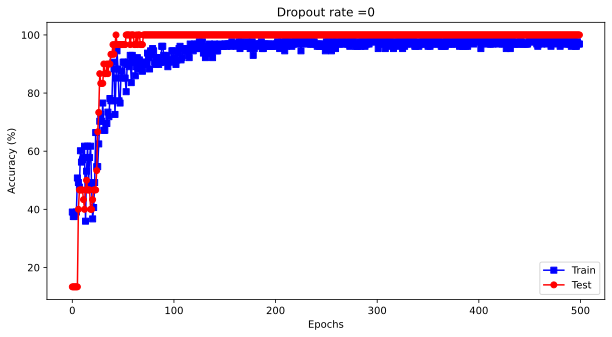

In [52]:
fig=plt.figure(figsize=(10,5))

plt.plot(trainAcc, 'bs-')
plt.plot(testAcc, 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate =%g'%dropoutrate)

plt.show()

In [53]:
dropoutRates=np.arange(10)/10
results=np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    ANNQC,lossfun,optimizer=createANewModel(dropoutRates[di])
    trainAcc,testAcc=trainTheModel(ANNQC,lossfun,optimizer)

    results[di,0]=np.mean(trainAcc[-100:])
    results[di,1]=np.mean(testAcc[-100:])